In [1]:
# Import Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import statistics
import fastcluster
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
from itertools import permutations
from scipy.spatial.distance import pdist, squareform
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors

In [2]:
bc = pd.read_csv('breastcancerdata.csv')
bc_noindex = pd.read_csv('breastcancerdata.csv', index_col=False) 
bc_noindex = bc_noindex.drop('Unnamed: 32', axis=1)
bc_columns = bc_noindex.columns

categorical_features = ['id','diagnosis']
numerical_features = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']
cat_data = bc_noindex[categorical_features]

scaler = MinMaxScaler(feature_range=(-1, 1))
x = pd.DataFrame(scaler.fit_transform(bc_noindex[numerical_features]))
x.columns = numerical_features
x_comb = pd.concat([cat_data, x], axis=1)
print(f'\n----> SCALED DATASET : \n\n{x_comb}')
s_row, s_col = x.shape


print(f'\n*\tSamples : {s_row}, Dimensions : {len(bc_noindex.columns)}')

#sns.pairplot(data=x_comb, hue='diagnosis', height=2)
#plt.plot()


----> SCALED DATASET : 

           id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0      842302         M     0.042075     -0.954684        0.091977  -0.272534   
1      842517         M     0.286289     -0.454853        0.231567   0.003181   
2    84300903         M     0.202991     -0.219479        0.191486  -0.101166   
3    84348301         M    -0.579819     -0.278323       -0.532997  -0.794189   
4    84358402         M     0.259785     -0.686845        0.261972  -0.021421   
..        ...       ...          ...           ...             ...        ...   
564    926424         M     0.379999     -0.142374        0.357335   0.132980   
565    926682         M     0.244640      0.253974        0.208071  -0.051962   
566    926954         M    -0.089498      0.242475       -0.108424  -0.393765   
567    927241         M     0.289129      0.327021        0.331076  -0.048568   
568     92751         B    -0.926262      0.003044       -0.942920  -0.968187   

 

In [3]:
## ----------- MEDIAN ABSOLUTE DEVIATION (MAD) correlation matrix ---------------

def compute_median_absolute_deviation(df):
    return df.apply(lambda col: np.absolute(col - col.median()))

def generate_corr_elems(columns):
    comb = permutations(columns, 2)
    perms = list(comb)
    diag = [(col, col) for col in columns]
    return diag + perms

def compute_corr_matrix_values(df, corr_elems):
    corr_values = []
    for elem in corr_elems:
        corr_values.append(df[elem[0]].append(df[elem[1]], ignore_index=True).median(axis=0))
    return corr_values

def construct_corr_matrix(corr_values, num_columns):
    matrix = np.diag(corr_values[:num_columns])
    k = 0
    for i in range(num_columns):
        for j in range(num_columns):
            if i != j:
                matrix[i, j] = corr_values[num_columns:][k]
                k += 1
    return matrix

# Compute the Median Absolute Deviation
x_MAD = compute_median_absolute_deviation(x)
print(f'\n ---> Median Absolute Deviation : \n\n{x_MAD}')

# Generate the correlation matrix elements
corr_elems = generate_corr_elems(x_MAD.columns)
print(f'\n ---> The elements of the corr matrix are : \n\n{corr_elems}')

# Compute the correlation matrix values
corr_values = compute_corr_matrix_values(x_MAD, corr_elems)
print(f'\n ---> The values of the corr_elems are : \n')
for i, value in zip(corr_elems, corr_values):
    print(f'*The median of the columns ({i[0]},{i[1]}) -> {value}')

# Construct the correlation matrix
corr_matrix = construct_corr_matrix(corr_values, x_MAD.shape[1])
print(f'\n ---> Correlation matrix : \n\n{corr_matrix}')


 ---> Median Absolute Deviation : 

     radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0       0.437314      0.572202        0.505286   0.381676         0.406789   
1       0.681528      0.072371        0.644876   0.657391         0.200957   
2       0.598230      0.163003        0.604796   0.553043         0.247901   
3       0.184580      0.104160        0.119688   0.139979         0.841925   
4       0.655024      0.304363        0.675282   0.632789         0.079986   
..           ...           ...             ...        ...              ...   
564     0.775238      0.240108        0.770645   0.787190         0.273179   
565     0.639879      0.636456        0.621381   0.602248         0.034847   
566     0.305741      0.624958        0.304886   0.260445         0.204387   
567     0.684367      0.709503        0.744385   0.605642         0.395956   
568     0.531024      0.385526        0.529611   0.313977         0.780717   

     compactness_mean  con


 ---> The values of the corr_elems are : 

*The median of the columns (radius_mean,radius_mean) -> 0.17984760282076762
*The median of the columns (texture_mean,texture_mean) -> 0.19005749070003386
*The median of the columns (perimeter_mean,perimeter_mean) -> 0.17566166816391382
*The median of the columns (area_mean,area_mean) -> 0.1300530222693531
*The median of the columns (smoothness_mean,smoothness_mean) -> 0.17152658662092635
*The median of the columns (compactness_mean,compactness_mean) -> 0.2001717686031531
*The median of the columns (concavity_mean,concavity_mean) -> 0.1895970009372071
*The median of the columns (concave points_mean,concave points_mean) -> 0.2001988071570575
*The median of the columns (symmetry_mean,symmetry_mean) -> 0.17272727272727284
*The median of the columns (fractal_dimension_mean,fractal_dimension_mean) -> 0.17775905644481904
*The median of the columns (radius_se,radius_se) -> 0.07676987144667757
*The median of the columns (texture_se,texture_se) -> 0.13

In [4]:
# Eigen Value & Eigen Vector Decomposition

# Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)

# Sort the eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

# Print the sorted eigenvalues and eigenvectors
print("Eigenvalues:")
print(eigenvalues)
print("\nEigenvectors:")
print(eigenvectors)

eig_vals_total = sum(eigenvalues)
explained_variance = [(i / eig_vals_total)*100 for i in eigenvalues]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)
print('\nExplained variance             : {}'.format(explained_variance))

print('Cumulative explained variance  : {}'.format(cum_explained_variance))

Eigenvalues:
[ 4.48646410e+00  7.63411950e-02  2.28977002e-02  1.64128636e-02
  1.18814415e-02  9.74832290e-03  8.45278528e-03  6.02766769e-03
  4.64788765e-03  3.74687846e-03  2.79754336e-03  2.25042852e-03
  1.52953382e-03  1.26089091e-03  7.11529952e-04  3.03494519e-04
 -3.83353477e-04 -7.99057208e-04 -1.24631206e-03 -1.36817189e-03
 -1.92072746e-03 -2.74311131e-03 -3.23379174e-03 -3.91702459e-03
 -5.00353720e-03 -5.58414641e-03 -8.62357204e-03 -1.46354066e-02
 -2.85814273e-02 -3.23313939e-02]

Eigenvectors:
[[ 2.00389686e-01 -6.25984643e-02 -6.10875953e-02 -1.54113685e-01
  -1.50312126e-01  2.03127058e-01 -9.36668585e-02  1.53682565e-01
  -1.70494428e-01  1.00741900e-01  1.33049367e-01 -1.82182887e-01
  -1.70929208e-01 -1.27317437e-01 -5.97296882e-02  7.30399090e-02
  -4.29775789e-01  2.87163095e-01 -2.98663252e-01 -2.00172692e-01
   3.59122933e-01 -2.14417556e-01  1.80433570e-02 -1.42224635e-01
   3.47756755e-02 -1.73291671e-01 -5.54843711e-02 -1.77265969e-01
   1.15831524e-01  1.


New projection:
            0         1         2         3         4        id diagnosis
0   -0.160821 -1.292318 -0.236244  0.094870 -0.401356    842302         M
1   -2.128089 -1.561701 -0.007862 -0.967749 -0.086540    842517         M
2   -1.050714 -1.597474 -0.152744 -0.496035 -0.205040  84300903         M
3    0.029325 -1.005417 -1.624313  0.509689  0.302629  84348301         M
4   -1.779131 -1.154955  0.092035 -0.398568 -0.446087  84358402         M
..        ...       ...       ...       ...       ...       ...       ...
564 -1.075588 -1.507947  0.444961 -0.471000 -0.410858    926424         M
565 -1.532946 -1.538945  0.005652 -0.657452  0.080475    926682         M
566 -2.302746 -1.443675 -0.289372 -0.382495  0.288513    926954         M
567  0.592071 -1.795654 -0.494250 -0.036525  0.023516    927241         M
568 -4.178375 -0.743501 -0.681307 -0.175498  0.463953     92751         B

[569 rows x 7 columns]


[]

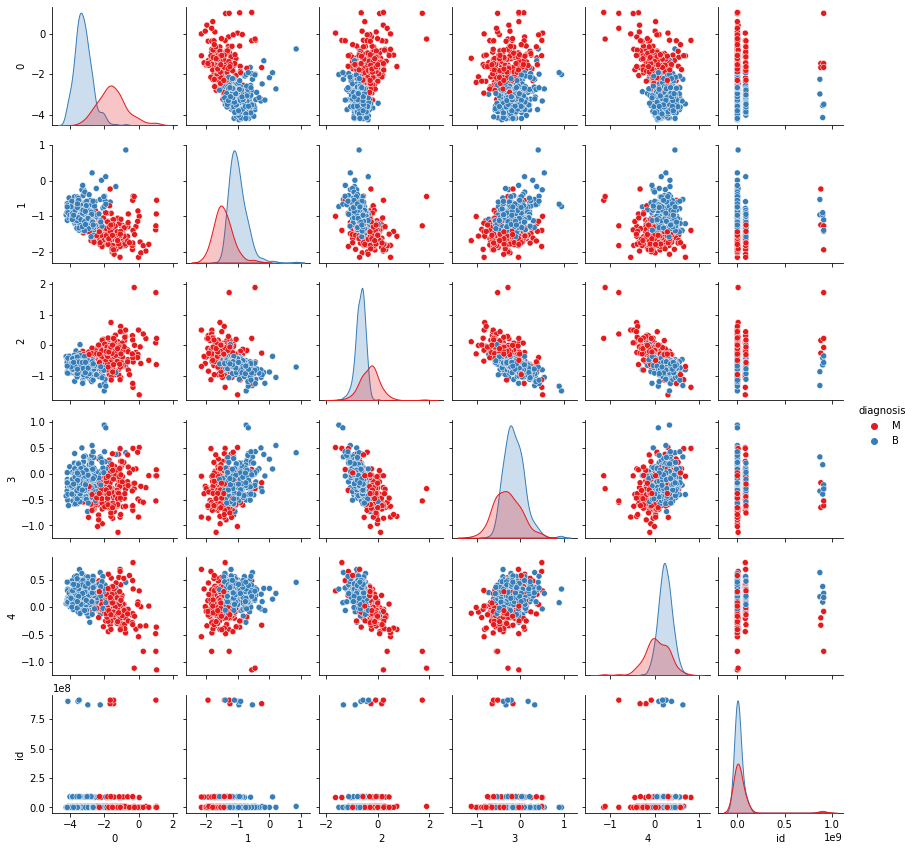

In [5]:
# Data Transformation.

# Select 'k' no of eigen vectors
k = 5
W = eigenvectors[:, :k] # Projection matrix

# Transform the original dataset
X_proj = x.dot(W)
X_proj_fin = pd.concat([X_proj, cat_data], axis=1)
X_proj_fin.to_csv('columns_heatmap.csv', index=False)
print('\nNew projection:')
print(X_proj_fin)
#X_proj_pd = pd.DataFrame(X_proj)
#print(X_proj)

sns.pairplot(data=X_proj_fin, hue='diagnosis', height=2, palette="Set1")
plt.plot()

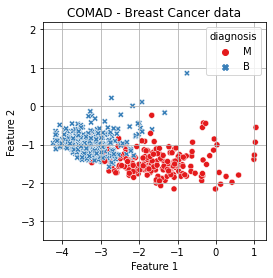

In [15]:
# Calculate the end points of the PC axes (scaled by the square root of the absolute eigenvalues)
pc_endpoints = eigenvectors * np.sqrt(np.abs(eigenvalues))
  
def Original():
    
    # Set the figure size
    plt.figure(figsize=(4, 4))

    df = pd.DataFrame(X_proj_fin)

    # Plot the DataFrame using Seaborn's scatterplot function
    sns.scatterplot(x=X_proj_fin[0], y=X_proj_fin[1],hue = X_proj_fin['diagnosis'], style=X_proj_fin['diagnosis'], data=df, palette="Set1" )

    # Show the plot
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('COMAD - Breast Cancer data')
    plt.grid(True)
    plt.axis('equal')
    plt.show()
    

Original()
#Transformed()

In [7]:
X_proj_1D = X_proj.to_numpy()
#X_proj_1D = X_proj.flatten()[::-1]

# Calculate the condensed distance matrix
condensed_dist_matrix = pdist(X_proj_1D)

# Convert the condensed distance matrix to a square distance matrix
dist_matrix = pd.DataFrame(squareform(condensed_dist_matrix))

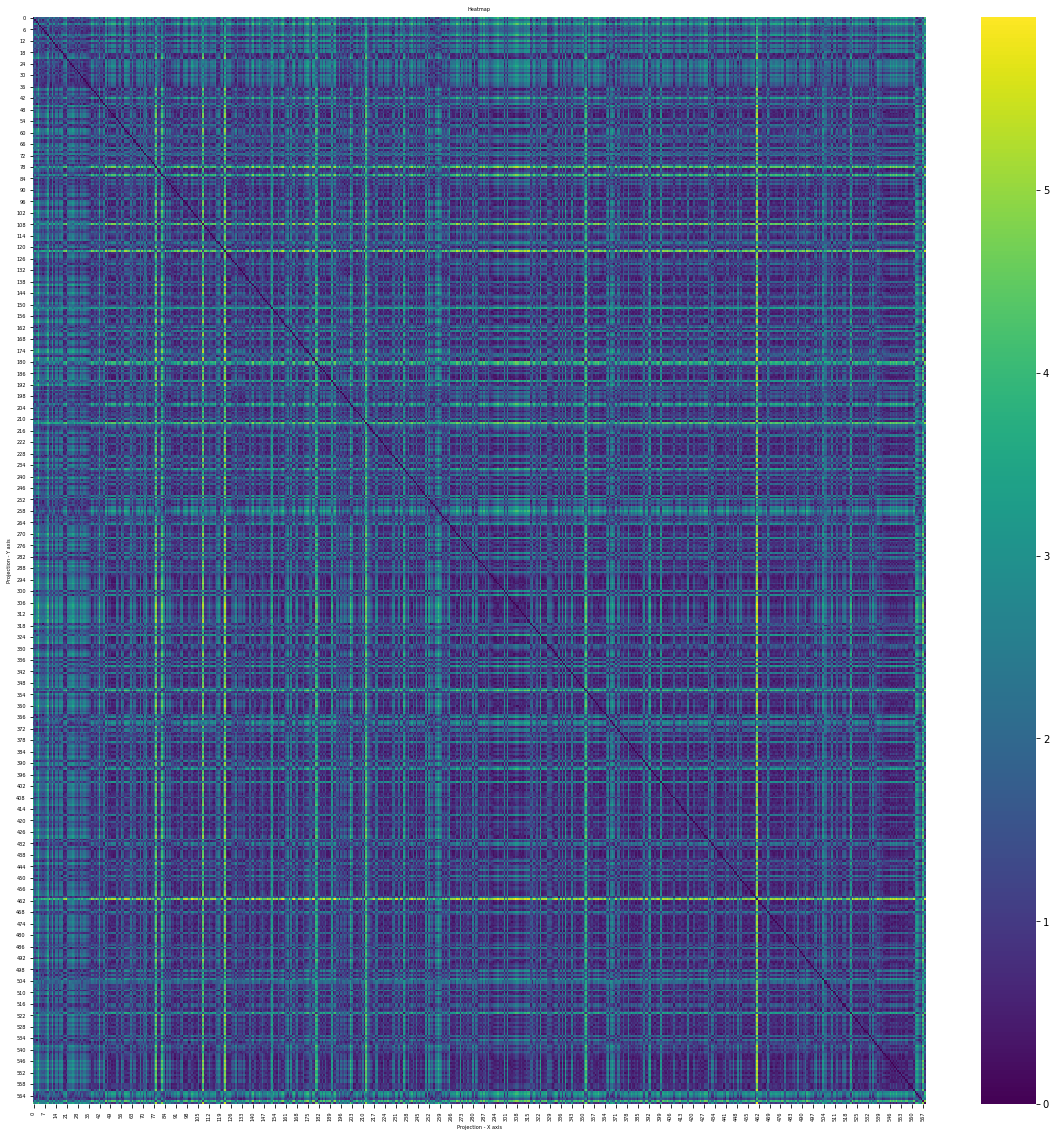

In [8]:
plt.figure(figsize=(20, 20))
sns.heatmap(dist_matrix, cmap='viridis', annot=False, annot_kws={"size": 10})

title_fontsize = 5
label_fontsize = 5

plt.title('Heatmap', fontsize=title_fontsize)
plt.xlabel('Projection - X axis', fontsize=label_fontsize)
plt.ylabel('Projection - Y axis', fontsize=label_fontsize)

ax = plt.gca()
ax.tick_params(axis='x', labelsize=label_fontsize)
ax.tick_params(axis='y', labelsize=label_fontsize)

plt.show()

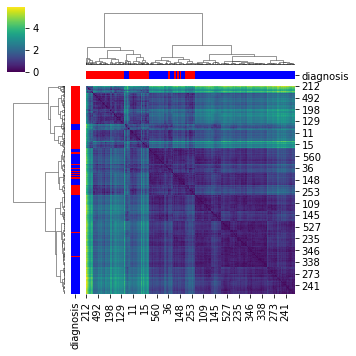

In [14]:
# Create a color mapping based on the species
species_color_mapping = X_proj_fin['diagnosis'].map({'M': 'red', 'B': 'blue'})

# Create a clustermap using the distance matrix and fastcluster with matching colors
linkage_matrix = fastcluster.linkage(condensed_dist_matrix, method='ward')
sns.clustermap(dist_matrix, cmap='viridis', figsize=(5, 5), row_linkage=linkage_matrix, col_linkage=linkage_matrix,
               row_colors=species_color_mapping, col_colors=species_color_mapping)

# Show the plot

plt.show()

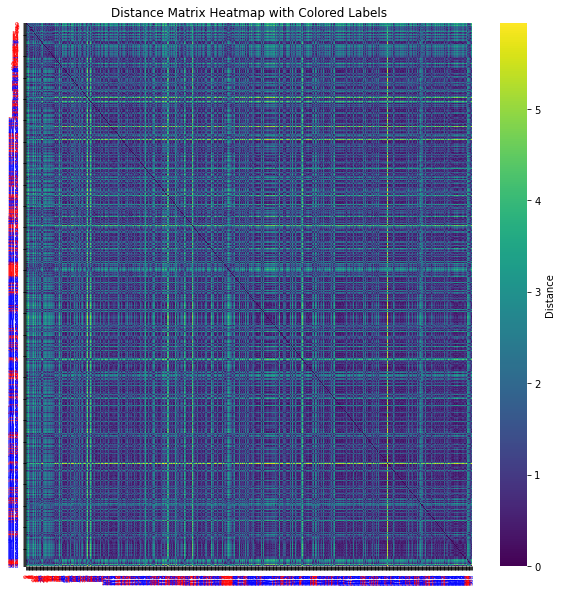

In [10]:
# Create a custom color mapping based on the species
species_color_mapping = X_proj_fin['diagnosis'].map({'M': 'red', 'B': 'blue'})
# Plot the distance matrix heatmap with colored labels
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(dist_matrix, cmap='viridis', ax=ax,
            cbar_kws={'label': 'Distance'})

# Set the tick labels and colors
ax.set_xticks(np.arange(dist_matrix.shape[0]) + 0.5)
ax.set_yticks(np.arange(dist_matrix.shape[0]) + 0.5)
ax.set_xticklabels(species_color_mapping.index, rotation=90, fontsize=6)
ax.set_yticklabels(species_color_mapping.index, rotation=0, fontsize=6)

# Color the tick labels
for tick, color in zip(ax.get_xticklabels(), species_color_mapping):
    tick.set_color(color)

for tick, color in zip(ax.get_yticklabels(), species_color_mapping):
    tick.set_color(color)

# Show the plot
plt.title('Distance Matrix Heatmap with Colored Labels')
plt.show()

In [11]:
# Dump to CSV

dist_matrix.to_csv('COMAD-BC.csv', index=False)

In [12]:
# Find the point you need
point = 200
X_proj_fin.iloc[[point]]['id']

200    877501
Name: id, dtype: int64

In [13]:
# Load Dataframe for K-nn
knn_df = X_proj_fin

# Select the columns corresponding to the features
features = knn_df[[0, 1, 2, 3, 4]]

# Create a NearestNeighbors object
nbrs = NearestNeighbors(n_neighbors=21, algorithm='ball_tree').fit(features)

# Find the point in the dataset corresponding to point 565
point_in_df = knn_df[knn_df['id'] == 877501][[0, 1, 2, 3, 4]]

# Find the 10 nearest neighbors
distances, indices = nbrs.kneighbors(point_in_df)

# Print the ids and point numbers of the 10 nearest neighbors
neighbors_df = pd.DataFrame(columns=['Neighbor', 'ID'])
for i in range(1, len(indices[0])):
    neighbor_index = indices[0][i]
    neighbor_id = knn_df.loc[neighbor_index, 'id']
    neighbor_point_no = knn_df.index[neighbor_index]
    neighbor_point_diag = knn_df.loc[neighbor_index, 'diagnosis']
    print(f"Neighbor {i}: ID = {neighbor_id}, Point No. = {neighbor_point_no}, Diagnosis = {neighbor_point_diag}")
    neighbors_df = neighbors_df.append({ 'Neighbor': i, 'ID': neighbor_id, 'Point No knn': neighbor_point_no, 'Diagnosis': neighbor_point_diag }, ignore_index=True)

# Number of nearest neighbors
k = 20

# Calculate the k-nearest neighbors from the distance matrix
nearest_neighbors = dist_matrix.iloc[200].values.argsort()[1:k+1]

# Create a DataFrame with the indices of the k-nearest neighbors
nearest_neighbors_df = pd.DataFrame(nearest_neighbors, columns=['Point No Dist Matrix'])
column_to_add = nearest_neighbors_df['Point No Dist Matrix']
neighbors_df = neighbors_df.join(column_to_add)

# Dump the dataset as a .csv file
neighbors_df.to_csv('knn_comad_pca.csv', index=False)

Neighbor 1: ID = 924632, Point No. = 554, Diagnosis = B
Neighbor 2: ID = 868202, Point No. = 135, Diagnosis = M
Neighbor 3: ID = 861648, Point No. = 90, Diagnosis = B
Neighbor 4: ID = 88147202, Point No. = 228, Diagnosis = B
Neighbor 5: ID = 911654, Point No. = 476, Diagnosis = B
Neighbor 6: ID = 911150, Point No. = 448, Diagnosis = B
Neighbor 7: ID = 869224, Point No. = 143, Diagnosis = B
Neighbor 8: ID = 922576, Point No. = 545, Diagnosis = B
Neighbor 9: ID = 87930, Point No. = 204, Diagnosis = B
Neighbor 10: ID = 922297, Point No. = 544, Diagnosis = B
Neighbor 11: ID = 906878, Point No. = 423, Diagnosis = B
Neighbor 12: ID = 91858, Point No. = 530, Diagnosis = B
Neighbor 13: ID = 9111843, Point No. = 452, Diagnosis = B
Neighbor 14: ID = 917896, Point No. = 523, Diagnosis = B
Neighbor 15: ID = 914333, Point No. = 495, Diagnosis = B
Neighbor 16: ID = 905686, Point No. = 415, Diagnosis = B
Neighbor 17: ID = 861597, Point No. = 88, Diagnosis = B
Neighbor 18: ID = 862009, Point No. = 93,